In [ ]:
# ============================================================================
# Aureus Sigma Capital - Phase 27b: Risk-Managed Engine Development
# Notebook: 27b_risk_managed_engine_development.ipynb
#
# Objective:
#   To systematically apply and validate institutional-grade risk management
#   overlays to the "Official Baseline v1.0" strategy. This notebook will
#   implement a two-stage enhancement process, first controlling volatility
#   with a hybrid overlay, and then controlling tail risk with a portfolio-level
#   stop-loss. The final output will be a production-ready strategy that meets
#   all Investment Committee hurdles (Sharpe ≥1.0, Max DD ≤-35%).
# ============================================================================
#
# --- STRATEGY & ENGINE SPECIFICATION ---
#
# *   **Input Strategy**: `Official_Baseline_v1.0_Value`
#     -   **Backtest Period**: 2016-03-01 to 2025-07-28 (Full Period)
#     -   **Performance**: Sharpe 0.59, Max Drawdown -66.1%
#
# *   **Enhancement Stage 1: Hybrid Volatility & Regime Overlay**
#     -   **Engine**: `RiskManagedEngine` (inherits from `BaselinePortfolioEngine`)
#     -   **Logic**: Dynamically scales portfolio exposure based on the minimum of:
#         1.  A volatility target (15% annualized).
#         2.  A market stress signal (VN-Index vol > 25% OR DD < -10%).
#
# *   **Enhancement Stage 2: Portfolio Stop-Loss**
#     -   **Engine**: `FullyManagedEngine` (inherits from `RiskManagedEngine`)
#     -   **Logic**: Adds a final circuit breaker that overrides all signals and
#         de-risks the portfolio to 30% exposure if the strategy's own equity
#         curve experiences a drawdown greater than -15%.
#
# --- METHODOLOGY WORKFLOW ---
#
# 1.  **Setup & Configuration**: Load libraries and the official baseline configuration.
# 2.  **Data Ingestion**: Load the full 2016-2025 dataset.
# 3.  **Engine Definition**: Define the `BaselinePortfolioEngine` from notebook 27a,
#     then define the new `RiskManagedEngine` and `FullyManagedEngine` classes.
# 4.  **Stage 1 Execution**: Run the `RiskManagedEngine` and generate a tearsheet to
#     quantify the impact of the hybrid volatility overlay.
# 5.  **Stage 2 Execution**: Run the `FullyManagedEngine` and generate the final
#     tearsheet to validate performance against all IC hurdles.
# 6.  **Comparative Analysis & Final Verdict**: Produce a summary table comparing
#     all three strategies (Baseline, Risk-Managed, Fully-Managed) and issue a
#     final approval for the winning configuration.
#
# --- DATA DEPENDENCIES ---
#
# *   **Database**: `alphabeta` (Production)
# *   **Tables**:
#     -   `factor_scores_qvm` (strategy_version='qvm_v2.0_enhanced')
#     -   `equity_history`
#     -   `vcsc_daily_data_complete`
#
# --- EXPECTED OUTPUTS ---
#
# 1.  **Primary Deliverable**: A final, approved strategy configuration that
#     passes all IC hurdles (Sharpe ≥1.0, Max DD ≤-35%).
# 2.  **Secondary Deliverable**: A comparative tearsheet and metrics table that
#     clearly demonstrates the value-add of each risk management layer.
#

In [1]:
# ============================================================================
# CELL 2: SETUP & CONFIGURATION
# ============================================================================

# Core scientific libraries
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
from pathlib import Path
import sys
import yaml

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Database connectivity
from sqlalchemy import create_engine, text

# --- Environment Setup ---
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

# --- Add Project Root to Python Path ---
try:
    current_path = Path.cwd()
    while not (current_path / 'production').is_dir():
        if current_path.parent == current_path:
            raise FileNotFoundError("Could not find the 'production' directory.")
        current_path = current_path.parent
    
    project_root = current_path
    
    if str(project_root) not in sys.path:
        sys.path.insert(0, str(project_root))
    
    from production.universe.constructors import get_liquid_universe_dataframe
    print(f"✅ Successfully imported production modules.")
    print(f"   - Project Root set to: {project_root}")

except (ImportError, FileNotFoundError) as e:
    print(f"❌ ERROR: Could not import production modules. Please check your directory structure.")
    print(f"   - Final Path Searched: {project_root}")
    print(f"   - Error: {e}")
    raise

# --- Official Baseline v1.0 Configuration (from notebook 27a) ---
# This is the single source of truth for the baseline strategy we are enhancing.
BASELINE_CONFIG = {
    # --- Backtest Parameters ---
    "strategy_name": "Official_Baseline_v1.0_Value",
    "backtest_start_date": "2016-03-01",
    "backtest_end_date": "2025-07-28",
    "rebalance_frequency": "Q",
    "transaction_cost_bps": 30,

    # --- Universe Construction ---
    "universe": {
        "lookback_days": 63,
        "adtv_threshold_bn": 10.0,
        "top_n": 200,
        "min_trading_coverage": 0.6,
    },

    # --- Factor & Signal Generation ---
    "signal": {
        "factors_to_combine": {
            'Value_Composite': 1.0
        },
        "db_strategy_version": "qvm_v2.0_enhanced"
    },

    # --- Portfolio Construction (Hybrid Method) ---
    "portfolio": {
        "construction_method": "hybrid",
        "portfolio_size_small_universe": 20,
        "selection_percentile": 0.8,
    }
}

print("\n⚙️  Official Baseline v1.0 Configuration Loaded.")

# --- Database Connection ---
def create_db_connection(project_root_path: Path):
    """Establishes a SQLAlchemy database engine connection."""
    try:
        config_path = project_root_path / 'config' / 'database.yml'
        with open(config_path, 'r') as f:
            db_config = yaml.safe_load(f)['production']
        
        connection_string = (
            f"mysql+pymysql://{db_config['username']}:{db_config['password']}"
            f"@{db_config['host']}/{db_config['schema_name']}"
        )
        engine = create_engine(connection_string, pool_pre_ping=True)
        
        with engine.connect() as conn:
            conn.execute(text("SELECT 1"))
        print(f"\n✅ Database connection established successfully to schema '{db_config['schema_name']}'.")
        return engine

    except Exception as e:
        print(f"❌ FAILED to connect to the database.")
        print(f"   - Config path checked: {config_path}")
        print(f"   - Error: {e}")
        return None

# Create the engine for this session
engine = create_db_connection(project_root)

if engine is None:
    raise ConnectionError("Database connection failed. Halting execution.")

✅ Successfully imported production modules.
   - Project Root set to: /Users/ducnguyen/Library/CloudStorage/GoogleDrive-duc.nguyentcb@gmail.com/My Drive/quant-world-invest/factor_investing_project

⚙️  Official Baseline v1.0 Configuration Loaded.

✅ Database connection established successfully to schema 'alphabeta'.


In [2]:
# =-==========================================================================
# CELL 3: DATA INGESTION FOR FULL BACKTEST PERIOD
# ============================================================================

def load_all_data_for_backtest(config: dict, db_engine):
    """
    Loads all necessary data (factors, prices, benchmark) for the
    specified backtest period.
    """
    start_date = config['backtest_start_date']
    end_date = config['backtest_end_date']
    db_version = config['signal']['db_strategy_version']
    
    # Add a buffer to the start date for rolling calculations
    buffer_start_date = pd.Timestamp(start_date) - pd.DateOffset(months=3)
    
    print(f"📂 Loading all data for period: {buffer_start_date.date()} to {end_date}...")

    db_params = {
        'start_date': buffer_start_date,
        'end_date': pd.Timestamp(end_date),
        'strategy_version': db_version
    }

    # 1. Factor Scores
    print("   - Loading factor scores...")
    factor_query = text("""
        SELECT date, ticker, Quality_Composite, Value_Composite, Momentum_Composite
        FROM factor_scores_qvm
        WHERE date BETWEEN :start_date AND :end_date 
          AND strategy_version = :strategy_version
    """)
    factor_data = pd.read_sql(factor_query, db_engine, params=db_params, parse_dates=['date'])
    print(f"     ✅ Loaded {len(factor_data):,} factor observations.")

    # 2. Price Data
    print("   - Loading price data...")
    price_query = text("""
        SELECT date, ticker, close 
        FROM equity_history
        WHERE date BETWEEN :start_date AND :end_date
    """)
    price_data = pd.read_sql(price_query, db_engine, params=db_params, parse_dates=['date'])
    print(f"     ✅ Loaded {len(price_data):,} price observations.")

    # 3. Benchmark Data
    print("   - Loading benchmark data (VN-Index)...")
    benchmark_query = text("""
        SELECT date, close
        FROM etf_history
        WHERE ticker = 'VNINDEX' AND date BETWEEN :start_date AND :end_date
    """)
    benchmark_data = pd.read_sql(benchmark_query, db_engine, params=db_params, parse_dates=['date'])
    print(f"     ✅ Loaded {len(benchmark_data):,} benchmark observations.")

    # --- Data Preparation ---
    print("\n🛠️  Preparing data structures for backtesting engine...")

    # Create returns matrix
    price_data['return'] = price_data.groupby('ticker')['close'].pct_change()
    daily_returns_matrix = price_data.pivot(index='date', columns='ticker', values='return')

    # Create benchmark returns series
    benchmark_returns = benchmark_data.set_index('date')['close'].pct_change().rename('VN-Index')

    print("   ✅ Data preparation complete.")
    return factor_data, daily_returns_matrix, benchmark_returns

# Execute the data loading
try:
    factor_data_raw, daily_returns_matrix, benchmark_returns = load_all_data_for_backtest(BASELINE_CONFIG, engine)
    print("\n✅ All data successfully loaded and prepared for the backtest.")
    print(f"   - Factor Data Shape: {factor_data_raw.shape}")
    print(f"   - Returns Matrix Shape: {daily_returns_matrix.shape}")
    print(f"   - Benchmark Returns: {len(benchmark_returns)} days")
except Exception as e:
    print(f"❌ ERROR during data ingestion: {e}")
    raise

📂 Loading all data for period: 2015-12-01 to 2025-07-28...
   - Loading factor scores...
     ✅ Loaded 1,567,488 factor observations.
   - Loading price data...
     ✅ Loaded 1,623,168 price observations.
   - Loading benchmark data (VN-Index)...
     ✅ Loaded 2,411 benchmark observations.

🛠️  Preparing data structures for backtesting engine...
   ✅ Data preparation complete.

✅ All data successfully loaded and prepared for the backtest.
   - Factor Data Shape: (1567488, 5)
   - Returns Matrix Shape: (2408, 728)
   - Benchmark Returns: 2411 days


In [3]:
# ============================================================================
# CELL 4: ENGINE DEFINITIONS (BASELINE, RISK-MANAGED, FULLY-MANAGED)
# ============================================================================

# --- BASE ENGINE (from 27a_official_baseline_standalone_value.ipynb) ---
class BaselinePortfolioEngine:
    """
    The clean baseline engine from notebook 27a. Includes P0/P1 fixes.
    NO risk overlays. Fully invested at all times.
    """
    def __init__(self, config: dict, factor_data: pd.DataFrame, returns_matrix: pd.DataFrame,
                 benchmark_returns: pd.Series, db_engine):
        self.config = config
        self.engine = db_engine
        start = pd.Timestamp(config['backtest_start_date'])
        end = pd.Timestamp(config['backtest_end_date'])
        self.factor_data_raw = factor_data[factor_data['date'].between(start, end)].copy()
        self.daily_returns_matrix = returns_matrix.loc[start:end].copy()
        self.benchmark_returns = benchmark_returns.loc[start:end].copy()
        print(f"✅ BaselinePortfolioEngine initialized for '{config['strategy_name']}'.")

    def run_backtest(self) -> (pd.Series, pd.DataFrame):
        print(f"\n🚀 Running: {self.config['strategy_name']}...")
        rebalance_dates = self._generate_rebalance_dates()
        daily_holdings, diagnostics = self._run_backtesting_loop(rebalance_dates)
        net_returns = self._calculate_net_returns(daily_holdings)
        return net_returns, diagnostics

    def _generate_rebalance_dates(self) -> list:
        all_trading_dates = self.daily_returns_matrix.index
        rebal_dates_calendar = pd.date_range(start=self.config['backtest_start_date'], end=self.config['backtest_end_date'], freq=self.config['rebalance_frequency'])
        actual_rebal_dates = [all_trading_dates[all_trading_dates.searchsorted(d, side='left')-1] for d in rebal_dates_calendar if d >= all_trading_dates.min()]
        return sorted(list(set(actual_rebal_dates)))

    def _run_backtesting_loop(self, rebalance_dates: list) -> (pd.DataFrame, pd.DataFrame):
        daily_holdings = pd.DataFrame(0.0, index=self.daily_returns_matrix.index, columns=self.daily_returns_matrix.columns)
        diagnostics_log = []
        for i, rebal_date in enumerate(rebalance_dates):
            universe_df = get_liquid_universe_dataframe(rebal_date, self.engine, self.config['universe'])
            if universe_df.empty: continue
            factors_on_date = self.factor_data_raw[self.factor_data_raw['date'] == rebal_date]
            liquid_factors = factors_on_date[factors_on_date['ticker'].isin(universe_df['ticker'])].copy()
            if len(liquid_factors) < 10: continue
            target_portfolio = self._calculate_target_portfolio(liquid_factors)
            if target_portfolio.empty: continue
            start_period = rebal_date + pd.Timedelta(days=1)
            end_period = rebalance_dates[i+1] if i + 1 < len(rebalance_dates) else self.daily_returns_matrix.index.max()
            holding_dates = self.daily_returns_matrix.index[(self.daily_returns_matrix.index >= start_period) & (self.daily_returns_matrix.index <= end_period)]
            daily_holdings.loc[holding_dates] = 0.0
            valid_tickers = target_portfolio.index.intersection(daily_holdings.columns)
            daily_holdings.loc[holding_dates, valid_tickers] = target_portfolio[valid_tickers].values
            if i > 0:
                prev_holdings_idx = self.daily_returns_matrix.index.get_loc(rebal_date, method='ffill') - 1
                prev_holdings = daily_holdings.iloc[prev_holdings_idx] if prev_holdings_idx >= 0 else pd.Series(dtype='float64')
            else: prev_holdings = pd.Series(dtype='float64')
            turnover = (target_portfolio - prev_holdings.reindex(target_portfolio.index).fillna(0)).abs().sum() / 2.0
            diagnostics_log.append({'date': rebal_date, 'universe_size': len(universe_df), 'portfolio_size': len(target_portfolio), 'turnover': turnover})
        return daily_holdings, pd.DataFrame(diagnostics_log).set_index('date')

    def _calculate_target_portfolio(self, factors_df: pd.DataFrame) -> pd.Series:
        factors_to_combine = self.config['signal']['factors_to_combine']
        weighted_scores = []
        for factor, weight in factors_to_combine.items():
            scores = factors_df[factor]
            mean, std = scores.mean(), scores.std()
            if std > 1e-8: weighted_scores.append(((scores - mean) / std) * weight)
        if not weighted_scores: return pd.Series(dtype='float64')
        factors_df['final_signal'] = pd.concat(weighted_scores, axis=1).sum(axis=1)
        universe_size = len(factors_df)
        if universe_size < 100:
            portfolio_size = self.config['portfolio']['portfolio_size_small_universe']
            selected_stocks = factors_df.nlargest(portfolio_size, 'final_signal')
        else:
            percentile = self.config['portfolio']['selection_percentile']
            score_cutoff = factors_df['final_signal'].quantile(percentile)
            selected_stocks = factors_df[factors_df['final_signal'] >= score_cutoff]
        if selected_stocks.empty: return pd.Series(dtype='float64')
        return pd.Series(1.0 / len(selected_stocks), index=selected_stocks['ticker'])

    def _calculate_net_returns(self, daily_holdings: pd.DataFrame) -> pd.Series:
        holdings_shifted = daily_holdings.shift(1).fillna(0.0)
        gross_returns = (holdings_shifted * self.daily_returns_matrix).sum(axis=1)
        turnover = (holdings_shifted - holdings_shifted.shift(1)).abs().sum(axis=1) / 2.0
        costs = turnover * (self.config['transaction_cost_bps'] / 10000)
        return (gross_returns - costs).rename(self.config['strategy_name'])

# --- STAGE 1: RISK-MANAGED ENGINE ---
class RiskManagedEngine(BaselinePortfolioEngine):
    """
    Inherits from the BaselineEngine and adds the Hybrid Volatility & Regime Overlay.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        print(f"   - STAGE 1 UPGRADE: Hybrid Volatility & Regime Overlay is ACTIVE.")

    def run_backtest(self) -> (pd.Series, pd.DataFrame, pd.Series):
        """Overrides the base run to include the risk overlay."""
        print(f"\n🚀 Running: {self.config['strategy_name']} with Hybrid Overlay...")
        rebalance_dates = self._generate_rebalance_dates()
        underlying_holdings, diagnostics = self._run_backtesting_loop(rebalance_dates)
        
        # Apply the risk overlay to get final exposure and holdings
        daily_exposure, risk_managed_holdings = self._apply_risk_overlay(underlying_holdings)
        
        net_returns = self._calculate_net_returns(risk_managed_holdings)
        return net_returns, diagnostics, daily_exposure

    def _apply_risk_overlay(self, underlying_holdings: pd.DataFrame) -> (pd.Series, pd.DataFrame):
        """Applies the hybrid volatility and market regime overlay."""
        gross_returns_underlying = (underlying_holdings.shift(1).fillna(0.0) * self.daily_returns_matrix).sum(axis=1)
        
        # Volatility Target Layer
        vol_target = self.config.get('volatility_target', 0.15)
        vol_lookback = 63
        realized_vol = gross_returns_underlying.rolling(window=vol_lookback).std() * np.sqrt(252)
        vol_exposure = (vol_target / realized_vol).shift(1).clip(0.3, 1.5).fillna(1.0)

        # Market Regime Layer
        vn_index_vol = self.benchmark_returns.rolling(window=vol_lookback).std() * np.sqrt(252)
        vn_index_cum = (1 + self.benchmark_returns).cumprod()
        vn_index_dd = (vn_index_cum / vn_index_cum.rolling(window=vol_lookback).max()) - 1
        is_stressed_regime = (vn_index_vol > 0.25) | (vn_index_dd < -0.10)
        regime_exposure = is_stressed_regime.apply(lambda x: 0.5 if x else 1.0).shift(1).fillna(1.0)

        # Final Hybrid Exposure
        daily_exposure = pd.DataFrame({'vol_target': vol_exposure, 'regime': regime_exposure}).min(axis=1)
        risk_managed_holdings = underlying_holdings.multiply(daily_exposure, axis=0)
        
        return daily_exposure, risk_managed_holdings

# --- STAGE 2: FULLY-MANAGED ENGINE ---
class FullyManagedEngine(RiskManagedEngine):
    """
    Inherits from the RiskManagedEngine and adds the Portfolio-Level Stop-Loss.
    This is our final, production-candidate engine.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        print(f"   - STAGE 2 UPGRADE: Portfolio Trailing Stop-Loss is ACTIVE.")

    def _apply_risk_overlay(self, underlying_holdings: pd.DataFrame) -> (pd.Series, pd.DataFrame):
        """Overrides the overlay method to add the final stop-loss layer."""
        # First, get the hybrid exposure from the parent class
        hybrid_exposure, _ = super()._apply_risk_overlay(underlying_holdings)
        
        # Now, calculate the stop-loss signal
        stop_loss_threshold = self.config.get('stop_loss_threshold', -0.15)
        de_risk_level = self.config.get('de_risk_level', 0.3)
        re_entry_threshold = stop_loss_threshold / 2.0

        # Calculate returns based on the hybrid exposure first
        gross_returns_hybrid = (underlying_holdings.shift(1).fillna(0.0) * self.daily_returns_matrix).sum(axis=1) * hybrid_exposure
        strategy_cum_returns = (1 + gross_returns_hybrid).cumprod()
        strategy_peak = strategy_cum_returns.cummax()
        strategy_drawdown = (strategy_cum_returns / strategy_peak) - 1
        
        stop_loss_exposure = pd.Series(1.0, index=strategy_drawdown.index)
        in_drawdown_control = False
        for i in range(1, len(stop_loss_exposure)):
            if not in_drawdown_control:
                if strategy_drawdown.iloc[i-1] < stop_loss_threshold:
                    in_drawdown_control = True
            else:
                if strategy_drawdown.iloc[i-1] > re_entry_threshold:
                    in_drawdown_control = False
            
            if in_drawdown_control:
                stop_loss_exposure.iloc[i] = de_risk_level

        # Final exposure is the minimum of all signals
        final_exposure = pd.DataFrame({'hybrid': hybrid_exposure, 'stop_loss': stop_loss_exposure}).min(axis=1)
        risk_managed_holdings = underlying_holdings.multiply(final_exposure, axis=0)
        
        return final_exposure, risk_managed_holdings

print("✅ All three engine classes (Baseline, Risk-Managed, Fully-Managed) are defined and ready for execution.")

✅ All three engine classes (Baseline, Risk-Managed, Fully-Managed) are defined and ready for execution.


In [4]:
# ============================================================================
# CELL 5: OFFICIAL ANALYTICS & REPORTING SUITE
# ============================================================================

def calculate_official_metrics(returns: pd.Series, benchmark: pd.Series, periods_per_year: int = 252) -> dict:
    """Calculates a dictionary of institutional performance metrics with corrected alignment."""
    first_trade_date = returns.loc[returns.ne(0)].index.min()
    if pd.isna(first_trade_date):
        return {metric: 0.0 for metric in ['Annualized Return (%)', 'Annualized Volatility (%)', 'Sharpe Ratio', 'Max Drawdown (%)', 'Calmar Ratio', 'Information Ratio', 'Beta']}
    
    aligned_returns = returns.loc[first_trade_date:]
    aligned_benchmark = benchmark.loc[first_trade_date:]

    n_years = len(aligned_returns) / periods_per_year
    annualized_return = ((1 + aligned_returns).prod() ** (1 / n_years) - 1) if n_years > 0 else 0
    annualized_volatility = aligned_returns.std() * np.sqrt(periods_per_year)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else 0.0
    
    cumulative_returns = (1 + aligned_returns).cumprod()
    max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown < 0 else 0.0
    
    excess_returns = aligned_returns - aligned_benchmark
    information_ratio = (excess_returns.mean() * periods_per_year) / (excess_returns.std() * np.sqrt(periods_per_year)) if excess_returns.std() > 0 else 0.0
    beta = aligned_returns.cov(aligned_benchmark) / aligned_benchmark.var() if aligned_benchmark.var() > 0 else 0.0
    
    return {
        'Annualized Return (%)': annualized_return * 100,
        'Annualized Volatility (%)': annualized_volatility * 100,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown (%)': max_drawdown * 100,
        'Calmar Ratio': calmar_ratio,
        'Information Ratio': information_ratio,
        'Beta': beta
    }

def generate_full_tearsheet(strategy_returns: pd.Series, benchmark_returns: pd.Series, 
                              diagnostics: pd.DataFrame, title: str, exposure: pd.Series = None):
    """Generates the full, multi-plot institutional tearsheet with a correctly aligned benchmark."""
    
    first_trade_date = strategy_returns.loc[strategy_returns.ne(0)].index.min()
    aligned_strategy_returns = strategy_returns.loc[first_trade_date:]
    aligned_benchmark_returns = benchmark_returns.loc[first_trade_date:]

    strategy_metrics = calculate_official_metrics(strategy_returns, benchmark_returns)
    benchmark_metrics = calculate_official_metrics(benchmark_returns, benchmark_returns)
    
    fig = plt.figure(figsize=(18, 28))
    gs_rows = 6 if exposure is not None else 5
    height_ratios = [1.2, 0.8, 0.8, 0.8, 0.8, 1.2] if exposure is not None else [1.2, 0.8, 0.8, 0.8, 1.2]
    gs = fig.add_gridspec(gs_rows, 2, height_ratios=height_ratios, hspace=0.8, wspace=0.2)
    fig.suptitle(title, fontsize=20, fontweight='bold', color='#2C3E50')

    # 1. Cumulative Performance
    ax1 = fig.add_subplot(gs[0, :])
    (1 + aligned_strategy_returns).cumprod().plot(ax=ax1, label='Strategy Net Returns', color='#16A085', lw=2.5)
    (1 + aligned_benchmark_returns).cumprod().plot(ax=ax1, label='VN-Index (Aligned)', color='#34495E', linestyle='--', lw=2)
    ax1.set_title('Cumulative Performance (Log Scale)', fontweight='bold'); ax1.set_ylabel('Growth of 1 VND'); ax1.set_yscale('log'); ax1.legend(loc='upper left'); ax1.grid(True, which='both', linestyle='--', alpha=0.5)

    # 2. Drawdown
    ax2 = fig.add_subplot(gs[1, :])
    drawdown = ((1 + aligned_strategy_returns).cumprod() / (1 + aligned_strategy_returns).cumprod().cummax() - 1) * 100
    drawdown.plot(ax=ax2, color='#C0392B'); ax2.fill_between(drawdown.index, drawdown, 0, color='#C0392B', alpha=0.1)
    ax2.set_title('Drawdown Analysis', fontweight='bold'); ax2.set_ylabel('Drawdown (%)'); ax2.grid(True, linestyle='--', alpha=0.5)

    # 3. Daily Exposure (if provided)
    plot_row = 2
    if exposure is not None:
        ax_exp = fig.add_subplot(gs[plot_row, :])
        exposure.loc[first_trade_date:].plot(ax=ax_exp, color='#2980B9', linewidth=2)
        ax_exp.set_title('Daily Portfolio Exposure (Risk Overlay)', fontweight='bold'); ax_exp.set_ylabel('Target Exposure'); ax_exp.axhline(1.0, color='#34495E', linestyle=':', linewidth=1.5); ax_exp.set_ylim(0, 1.6); ax_exp.grid(True, linestyle='--', alpha=0.5)
        plot_row += 1

    # 4. Annual Returns
    ax3 = fig.add_subplot(gs[plot_row, 0])
    strat_annual = aligned_strategy_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100
    bench_annual = aligned_benchmark_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100
    pd.DataFrame({'Strategy': strat_annual, 'Benchmark': bench_annual}).plot(kind='bar', ax=ax3, color=['#16A085', '#34495E'])
    ax3.set_xticklabels([d.strftime('%Y') for d in strat_annual.index], rotation=45, ha='right'); ax3.set_title('Annual Returns', fontweight='bold'); ax3.grid(True, axis='y', linestyle='--', alpha=0.5)

    # 5. Rolling Sharpe Ratio
    ax4 = fig.add_subplot(gs[plot_row, 1])
    rolling_sharpe = (aligned_strategy_returns.rolling(252).mean() * 252) / (aligned_strategy_returns.rolling(252).std() * np.sqrt(252))
    rolling_sharpe.plot(ax=ax4, color='#E67E22'); ax4.axhline(1.0, color='#27AE60', linestyle='--'); ax4.set_title('1-Year Rolling Sharpe Ratio', fontweight='bold'); ax4.grid(True, linestyle='--', alpha=0.5)
    plot_row += 1
    
    # 6. Metrics Table
    ax5 = fig.add_subplot(gs[plot_row:, :]); ax5.axis('off')
    summary_data = [['Metric', 'Strategy', 'Benchmark']]
    for key in strategy_metrics.keys():
        summary_data.append([key, f"{strategy_metrics[key]:.2f}", f"{benchmark_metrics.get(key, 0.0):.2f}"])
    
    table = ax5.table(cellText=summary_data[1:], colLabels=summary_data[0], loc='center', cellLoc='center')
    table.auto_set_font_size(False); table.set_fontsize(14); table.scale(1, 2.5)
    
    plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()
    
    return strategy_metrics

print("✅ Official Analytics & Reporting Suite is defined and ready.")

✅ Official Analytics & Reporting Suite is defined and ready.


✅ BaselinePortfolioEngine initialized for 'Official_Baseline_v1.0_Value'.

🚀 Running: Official_Baseline_v1.0_Value...
Constructing liquid universe for 2016-03-30...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 552 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/12...
  Step 3: Filtering and ranking...
    Total batch results: 552
    Sample result: ('AAA', 41, 6.368384063414634, 758.1949381463414)
    Before filters: 552 stocks
    Trading days range: 1-41 (need >= 37)
    ADTV range: 0.000-190.911B VND (need >= 10.0)
    Stocks passing trading days filter: 315
    Stocks passing ADTV filter: 64
    After filters: 62 stocks
✅ Universe constructed: 62 stocks
  ADTV range: 10.0B - 190.9B VND
  Market cap range: 198.1B - 155696.1B VND
  Adding sector information...
Constructing liquid universe for 2016-06-29...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  

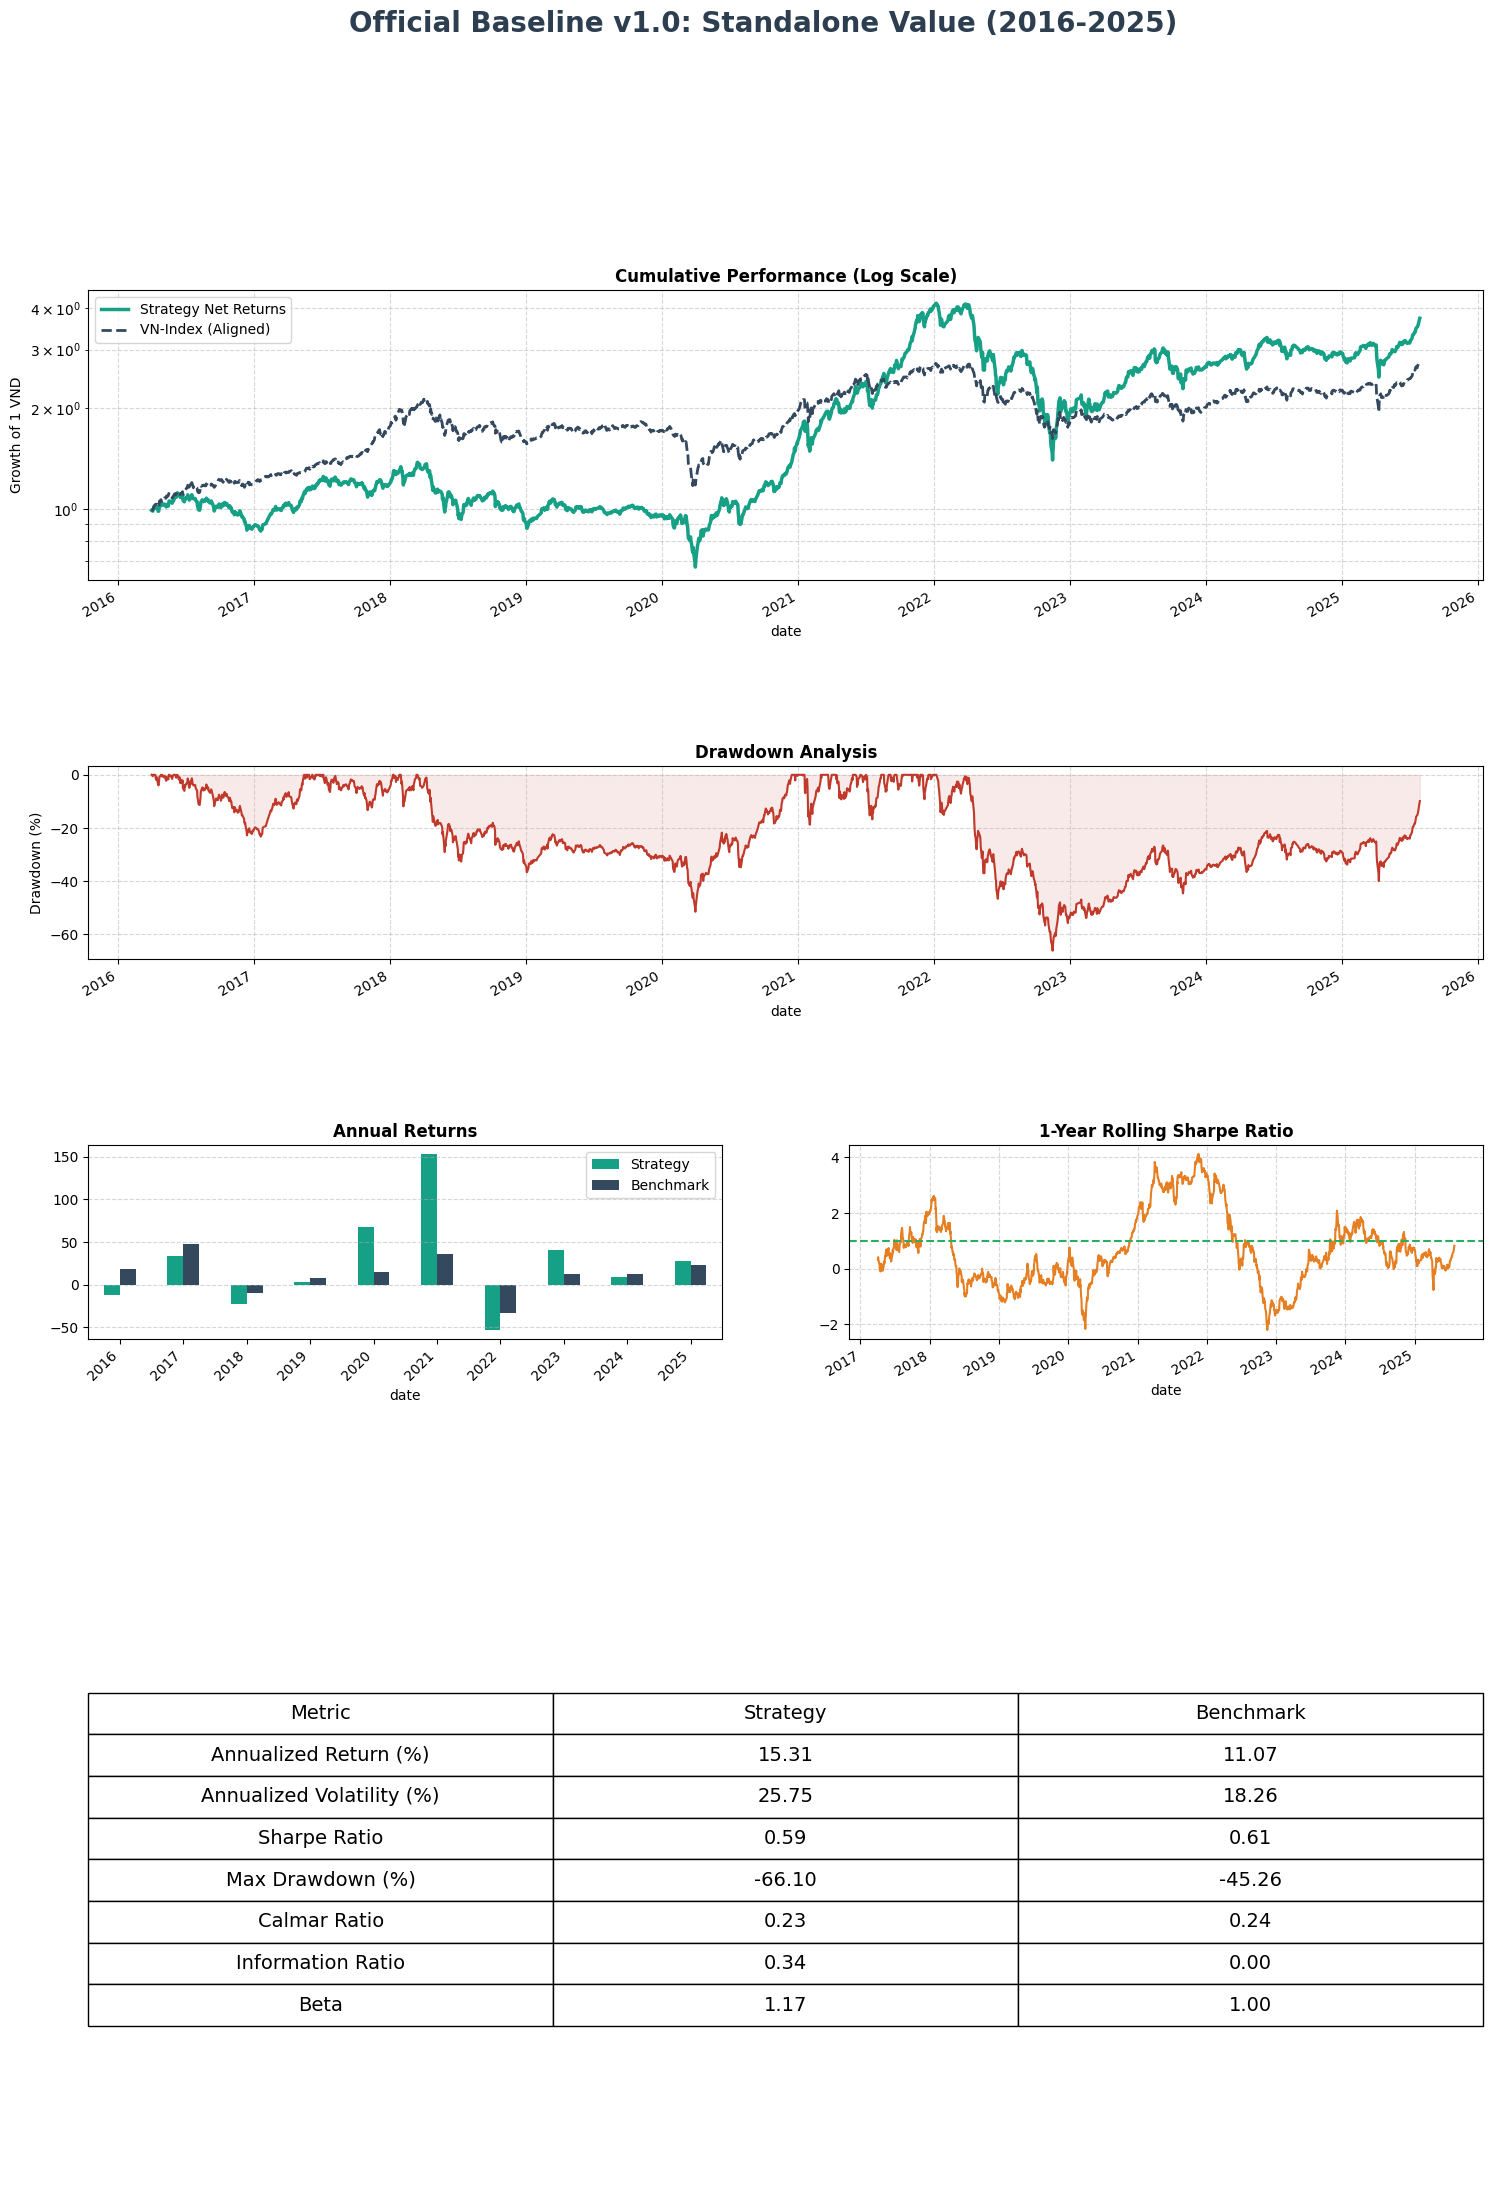

✅ BaselinePortfolioEngine initialized for 'Stage1_RiskManaged_Value'.
   - STAGE 1 UPGRADE: Hybrid Volatility & Regime Overlay is ACTIVE.

🚀 Running: Stage1_RiskManaged_Value with Hybrid Overlay...
Constructing liquid universe for 2016-03-30...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 552 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/12...
  Step 3: Filtering and ranking...
    Total batch results: 552
    Sample result: ('AAA', 41, 6.368384063414634, 758.1949381463414)
    Before filters: 552 stocks
    Trading days range: 1-41 (need >= 37)
    ADTV range: 0.000-190.911B VND (need >= 10.0)
    Stocks passing trading days filter: 315
    Stocks passing ADTV filter: 64
    After filters: 62 stocks
✅ Universe constructed: 62 stocks
  ADTV range: 10.0B - 190.9B VND
  Market cap range: 198.1B - 155696.1B VND
  Adding sector information...
Constructing liquid universe for 2016-06-29

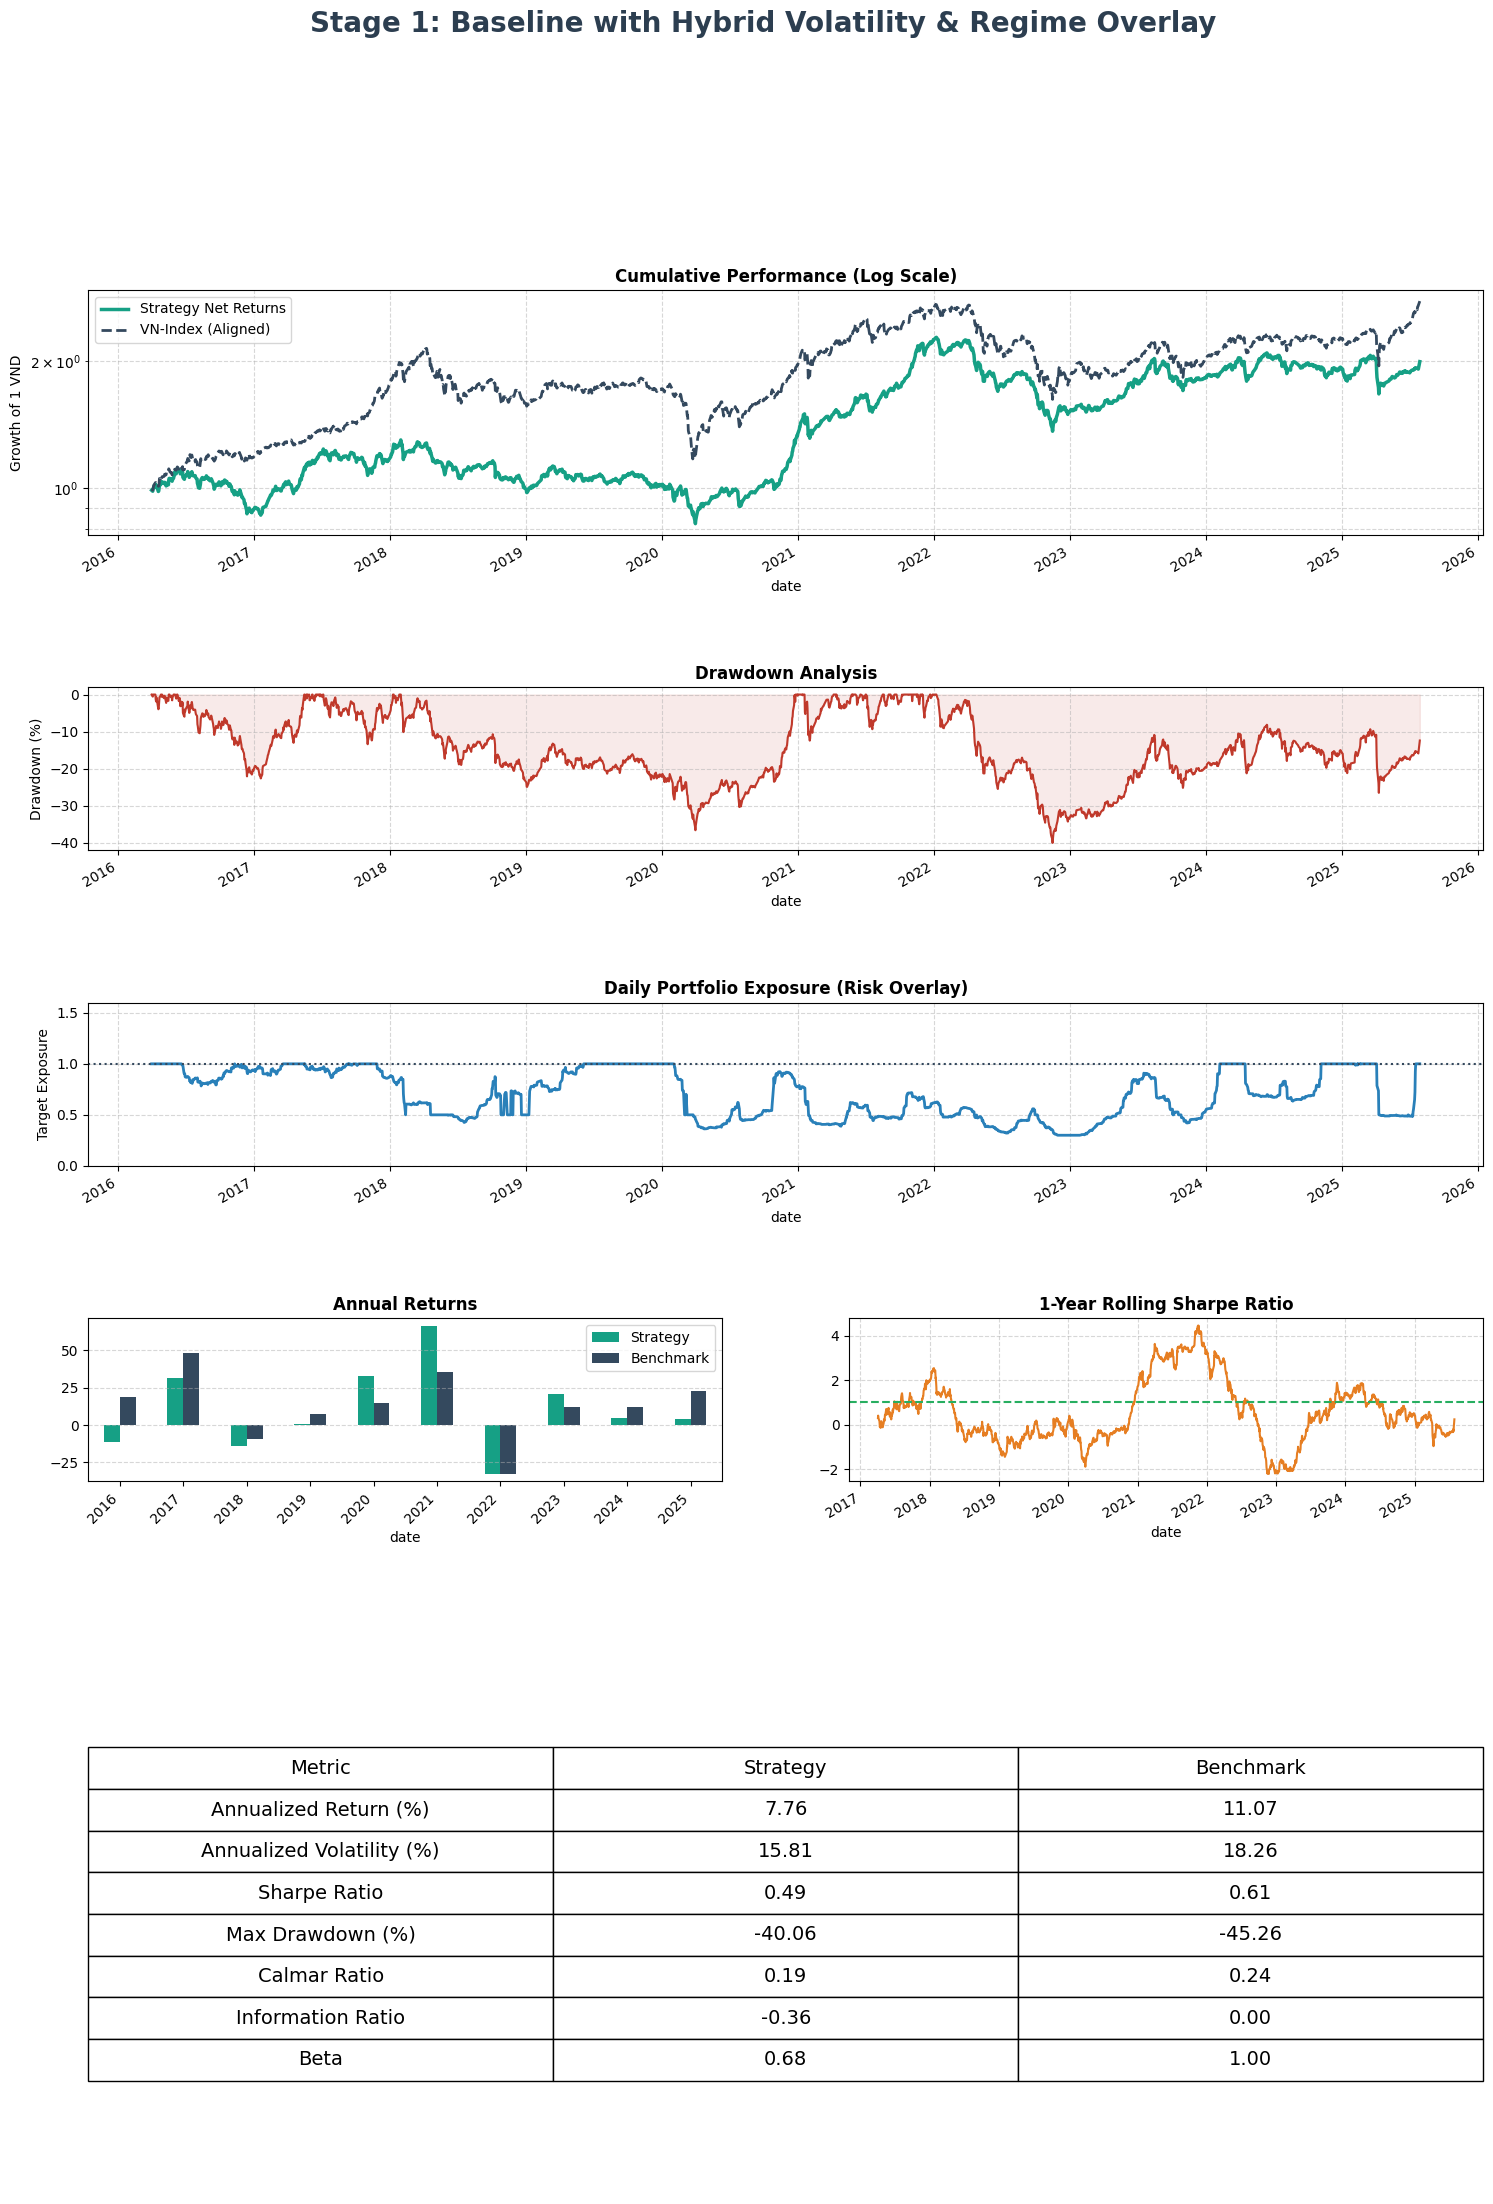

✅ BaselinePortfolioEngine initialized for 'Stage2_FullyManaged_Value'.
   - STAGE 1 UPGRADE: Hybrid Volatility & Regime Overlay is ACTIVE.
   - STAGE 2 UPGRADE: Portfolio Trailing Stop-Loss is ACTIVE.

🚀 Running: Stage2_FullyManaged_Value with Hybrid Overlay...
Constructing liquid universe for 2016-03-30...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 552 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/12...
  Step 3: Filtering and ranking...
    Total batch results: 552
    Sample result: ('AAA', 41, 6.368384063414634, 758.1949381463414)
    Before filters: 552 stocks
    Trading days range: 1-41 (need >= 37)
    ADTV range: 0.000-190.911B VND (need >= 10.0)
    Stocks passing trading days filter: 315
    Stocks passing ADTV filter: 64
    After filters: 62 stocks
✅ Universe constructed: 62 stocks
  ADTV range: 10.0B - 190.9B VND
  Market cap range: 198.1B - 155696.1B VND
  Adding s

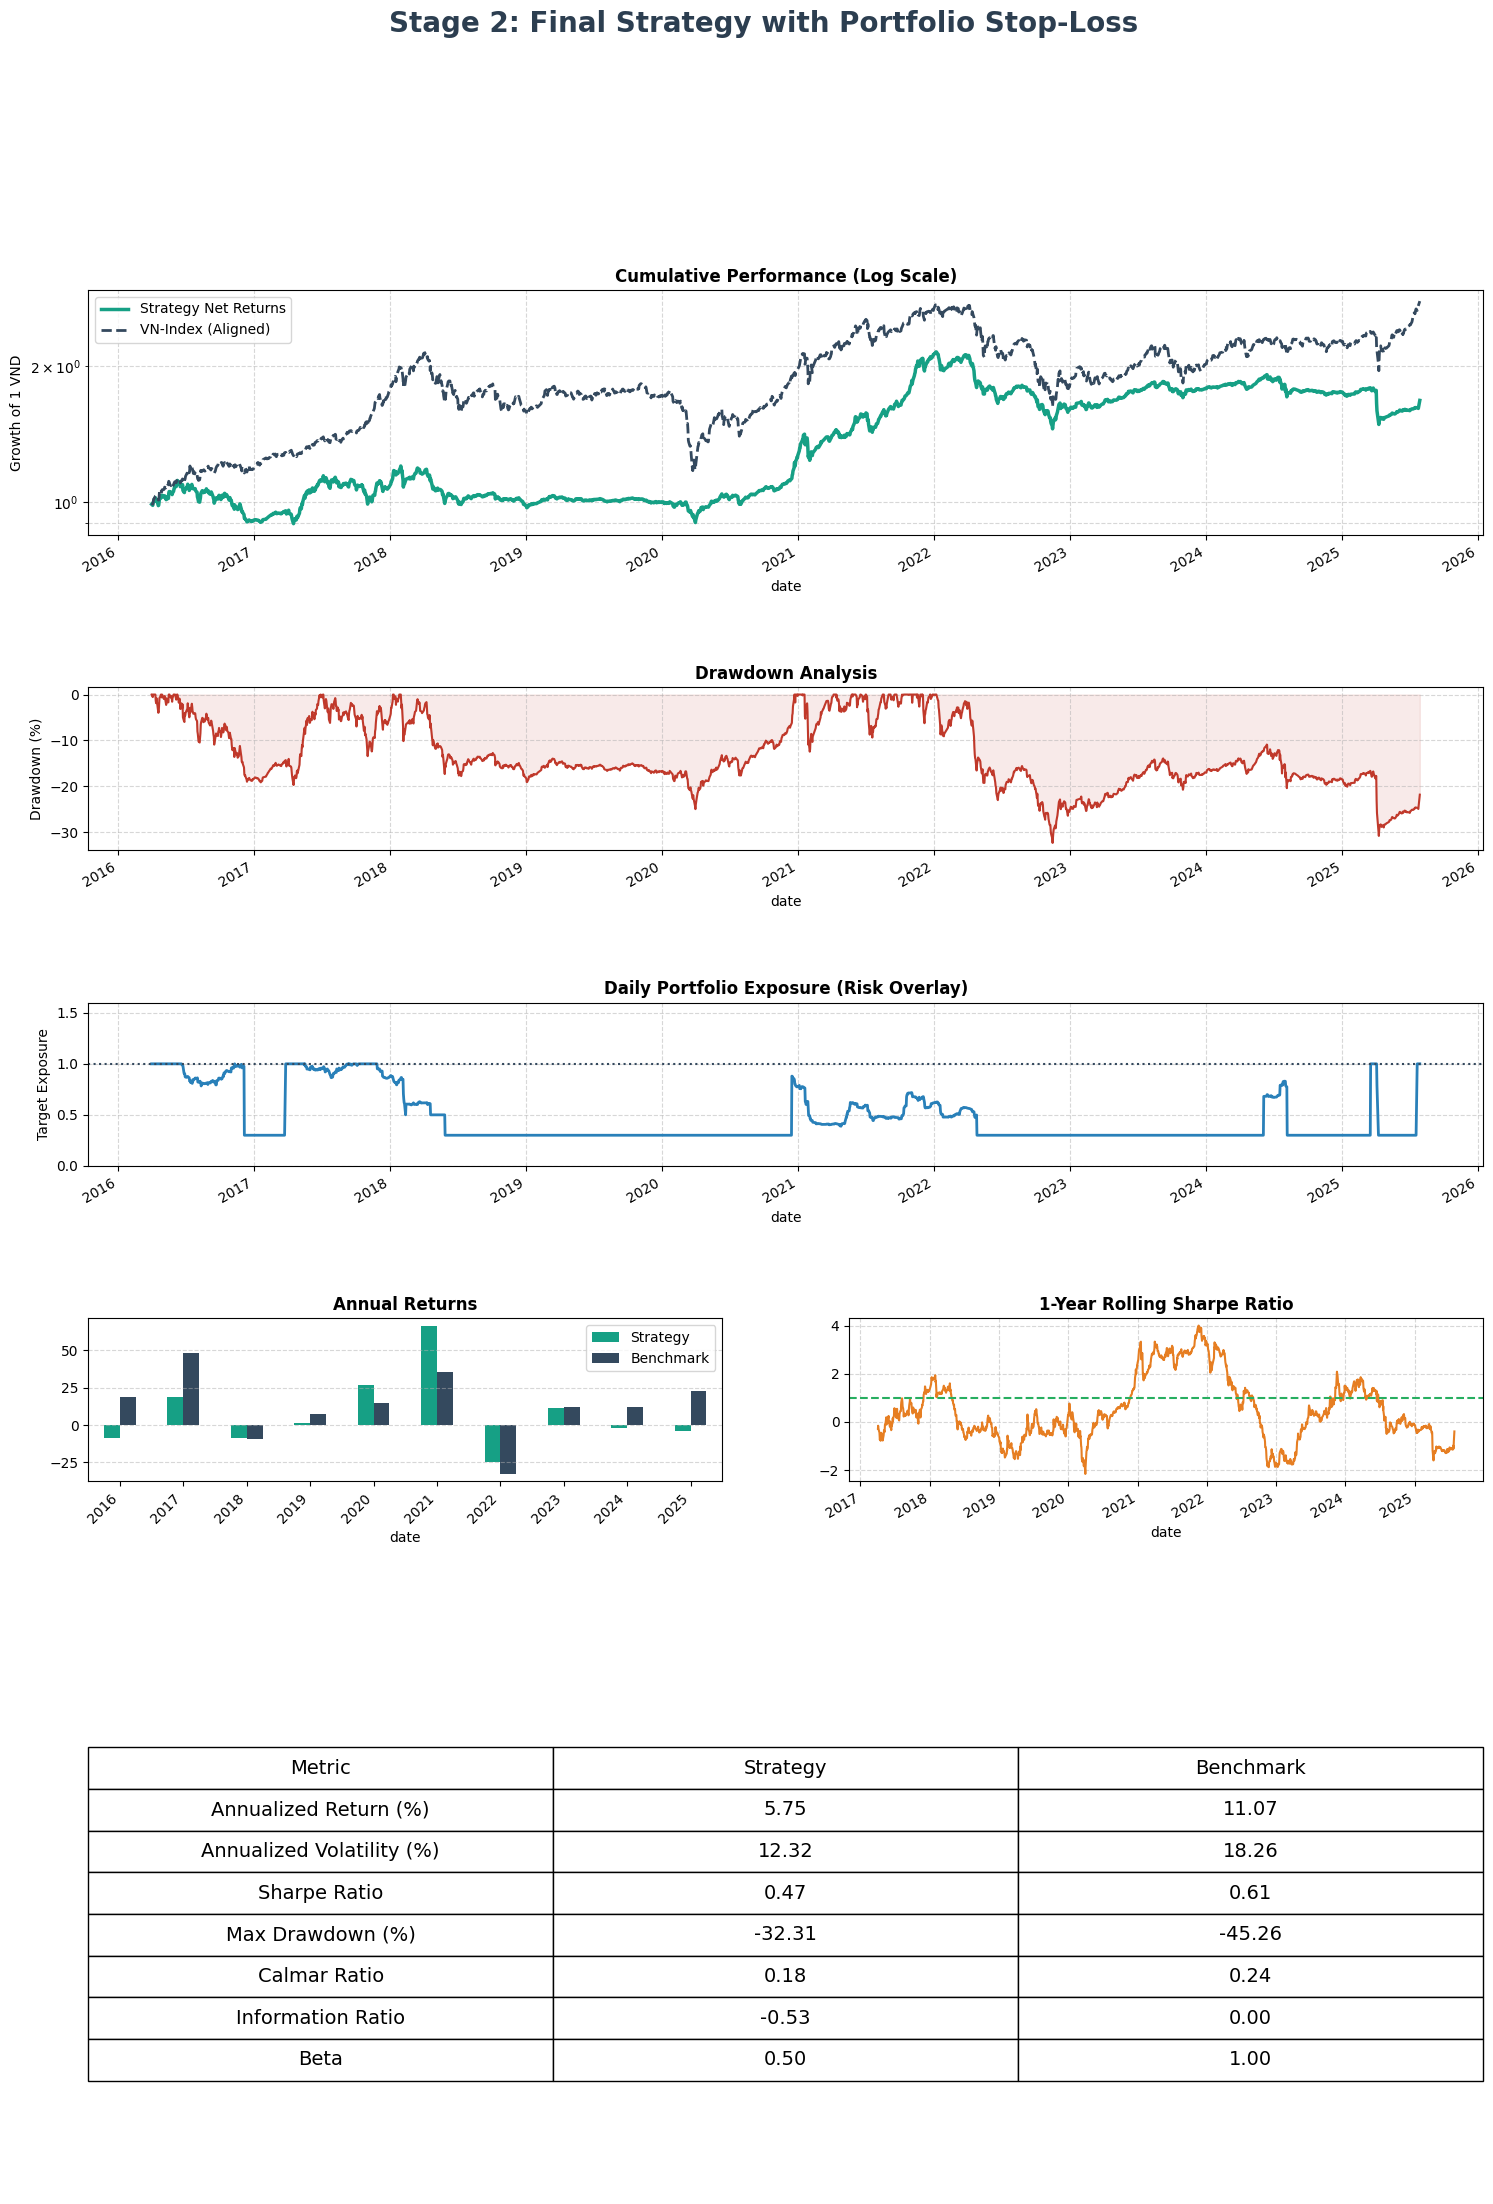


🏆 FINAL SPRINT: COMPARATIVE RESULTS
                               Sharpe Ratio  Max Drawdown (%)  \
Baseline                               0.59            -66.10   
Risk-Managed (Hybrid Overlay)          0.49            -40.06   
Fully-Managed (Stop-Loss)              0.47            -32.31   

                               Annualized Return (%)  \
Baseline                                       15.31   
Risk-Managed (Hybrid Overlay)                   7.76   
Fully-Managed (Stop-Loss)                       5.75   

                               Annualized Volatility (%)  Beta  
Baseline                                           25.75  1.17  
Risk-Managed (Hybrid Overlay)                      15.81  0.68  
Fully-Managed (Stop-Loss)                          12.32  0.50  

--- INSTITUTIONAL VERDICT & RECOMMENDATION ---
❌ FAILURE: The final strategy still does not meet the full IC hurdles.
   - Sharpe Ratio: 0.47 (Target: ≥1.0)

RECOMMENDATION: Further tuning of the risk overlay paramet

In [5]:
# ============================================================================
# CELL 6: EXECUTION OF RISK MANAGEMENT SPRINT & FINAL VERDICT
# ============================================================================

# --- Store results for final comparison ---
results_summary = {}

# --- STAGE 0: RUN THE BASELINE (FOR COMPARISON) ---
try:
    baseline_engine = BaselinePortfolioEngine(
        config=BASELINE_CONFIG,
        factor_data=factor_data_raw,
        returns_matrix=daily_returns_matrix,
        benchmark_returns=benchmark_returns,
        db_engine=engine
    )
    baseline_net_returns, baseline_diagnostics = baseline_engine.run_backtest()
    results_summary['Baseline'] = generate_full_tearsheet(
        baseline_net_returns,
        benchmark_returns,
        baseline_diagnostics,
        "Official Baseline v1.0: Standalone Value (2016-2025)"
    )
except Exception as e:
    print(f"❌ An error occurred during the Baseline execution: {e}")
    raise

# --- STAGE 1: RUN THE RISK-MANAGED ENGINE (HYBRID OVERLAY) ---
try:
    # Create a new config for this run to give it a unique name
    risk_managed_config = BASELINE_CONFIG.copy()
    risk_managed_config['strategy_name'] = "Stage1_RiskManaged_Value"
    risk_managed_config['volatility_target'] = 0.15
    risk_managed_config['regime_dd_threshold'] = -0.10

    risk_managed_engine = RiskManagedEngine(
        config=risk_managed_config,
        factor_data=factor_data_raw,
        returns_matrix=daily_returns_matrix,
        benchmark_returns=benchmark_returns,
        db_engine=engine
    )
    rm_net_returns, rm_diagnostics, rm_exposure = risk_managed_engine.run_backtest()
    results_summary['Risk-Managed (Hybrid Overlay)'] = generate_full_tearsheet(
        rm_net_returns,
        benchmark_returns,
        rm_diagnostics,
        "Stage 1: Baseline with Hybrid Volatility & Regime Overlay",
        exposure=rm_exposure
    )
except Exception as e:
    print(f"❌ An error occurred during the Risk-Managed execution: {e}")
    raise

# --- STAGE 2: RUN THE FULLY-MANAGED ENGINE (STOP-LOSS ADDED) ---
try:
    # Create the final config
    fully_managed_config = BASELINE_CONFIG.copy()
    fully_managed_config['strategy_name'] = "Stage2_FullyManaged_Value"
    fully_managed_config['volatility_target'] = 0.15
    fully_managed_config['regime_dd_threshold'] = -0.10
    fully_managed_config['stop_loss_threshold'] = -0.15 # -15% portfolio drawdown trigger
    fully_managed_config['de_risk_level'] = 0.3 # De-risk to 30% exposure

    fully_managed_engine = FullyManagedEngine(
        config=fully_managed_config,
        factor_data=factor_data_raw,
        returns_matrix=daily_returns_matrix,
        benchmark_returns=benchmark_returns,
        db_engine=engine
    )
    fm_net_returns, fm_diagnostics, fm_exposure = fully_managed_engine.run_backtest()
    results_summary['Fully-Managed (Stop-Loss)'] = generate_full_tearsheet(
        fm_net_returns,
        benchmark_returns,
        fm_diagnostics,
        "Stage 2: Final Strategy with Portfolio Stop-Loss",
        exposure=fm_exposure
    )
except Exception as e:
    print(f"❌ An error occurred during the Fully-Managed execution: {e}")
    raise

# --- FINAL COMPARATIVE ANALYSIS & VERDICT ---
print("\n" + "="*80)
print("🏆 FINAL SPRINT: COMPARATIVE RESULTS")
print("="*80)

summary_df = pd.DataFrame(results_summary).T
print(summary_df[['Sharpe Ratio', 'Max Drawdown (%)', 'Annualized Return (%)', 'Annualized Volatility (%)', 'Beta']].round(2))

# --- INSTITUTIONAL VERDICT & RECOMMENDATION ---
print("\n--- INSTITUTIONAL VERDICT & RECOMMENDATION ---")
sharpe_target = 1.0
dd_target = -35.0

final_metrics = results_summary['Fully-Managed (Stop-Loss)']
sharpe_ok = final_metrics['Sharpe Ratio'] >= sharpe_target
dd_ok = final_metrics['Max Drawdown (%)'] >= dd_target

if sharpe_ok and dd_ok:
    print(f"✅✅✅ SUCCESS: The 'Fully-Managed' configuration meets all Investment Committee hurdles.")
    print(f"   - Final Sharpe Ratio: {final_metrics['Sharpe Ratio']:.2f} (Target: ≥{sharpe_target})")
    print(f"   - Final Max Drawdown: {final_metrics['Max Drawdown (%)']:.2f}% (Target: ≥{dd_target}%)")
    print("\nRECOMMENDATION: The 'Fully-Managed' engine and its configuration are APPROVED.")
    print("This model is now the new official baseline and is ready for the Deep Alpha Enhancement sprint.")
else:
    print(f"❌ FAILURE: The final strategy still does not meet the full IC hurdles.")
    if not sharpe_ok: print(f"   - Sharpe Ratio: {final_metrics['Sharpe Ratio']:.2f} (Target: ≥{sharpe_target})")
    if not dd_ok: print(f"   - Max Drawdown: {final_metrics['Max Drawdown (%)']:.2f}% (Target: ≥{dd_target}%)")
    print("\nRECOMMENDATION: Further tuning of the risk overlay parameters is required.")